*Andrew Calderwood*

In [3]:
import os
from os.path import basename, dirname, join, exists
import sys

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

from scipy.optimize import minimize

from datetime import datetime
from datetime import timedelta
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# from pandas.tseries import converter

In [4]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 
import flopy.utils.binaryfile as bf


In [26]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'


data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [6]:
git_dir = join(doc_dir, 'GitHub','CosumnesRiverRecharge')
fxn_dir = git_dir+'/python_utilities'
if fxn_dir not in sys.path:
    sys.path.append(fxn_dir)
# sys.path
# import muskingum_recharge as mr

from importlib import reload
# reload(mr)

In [7]:
nrow = 100
ncol = 230
rows = np.repeat(np.arange(0,nrow),ncol)
cols = np.tile(np.arange(0,ncol),nrow)

# dem data for cropping above land surface
# dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_linear.tsv')
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

zs = gpd.read_file(gwfm_dir+'/DIS_data/grid_elevation_m_statistics.shp')
# columns with different quantiles 0 to 100% of elevation
q_cols = zs.columns[zs.columns.str.contains('perc')]
df_elevs = zs[q_cols]

# convert quantile dataframe to a 3D array
arr_elev = np.zeros((df_elevs.shape[1], zs.row.max(),zs.column.max()))
for n in np.arange(0,df_elevs.shape[1]):
    arr_elev[n, zs.row-1, zs.column-1] = df_elevs.iloc[:,n]

# No flow routing, recharge loss only

In [8]:
# Q_cfs = 22500 # 5 year
# # Q_cfs = 2000 # 1ish year

# Q_cms = Q_cfs*(0.3048**3) # convert to cubic meters per second


In [9]:
import muskingum_recharge
reload(muskingum_recharge)

from muskingum_recharge import min_Q, mannings, calc_depth_arr, xs_setback, gridded_interpolation


In [10]:
import h5py
f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

In [11]:
setbacks = np.arange(0, 3400,200)
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_right_m')
num_segs = xs_levee_smooth.shape[1]

# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

# load flood typology characteristics (based on daily data 1908 - 2014) - median values 
#"cms_pk" for peak discharge, "pk_loc" for time to peak, and "log_no_d" for duration
flood_type = pd.read_csv(join(box_dir, 'whipple_grp6_w97ftmedians.csv'),index_col='Group.1')


In [12]:
Q_cms = flood_type.loc[1,'cms_pk']

In [31]:
soil_thick=2
# fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth.tsv' # from linear dem but also seems off
fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth_dem_mean.tsv' # mean dem with newest cleaning function

# units of m/day
soil_K_out = np.loadtxt(fn, delimiter='\t')
soil_K = np.reshape(soil_K_out, (100, nrow, ncol))
# convert soil conductivity from m/d to m/s and apply vertical anisotropy factor
vani = 100
soil_K = (soil_K/vani)/86400

In [29]:
# flow_percentile=87 # for permeameter (flow threshold)
flow_percentile=6 # for connec3d (points of connectivity)

hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, nrow, ncol))


In [36]:
# I checked the new soil maps against the HCP maps and they align now.
# plt.imshow(soil_K[0])
# plt.show()
# plt.imshow(hf_tot[0])

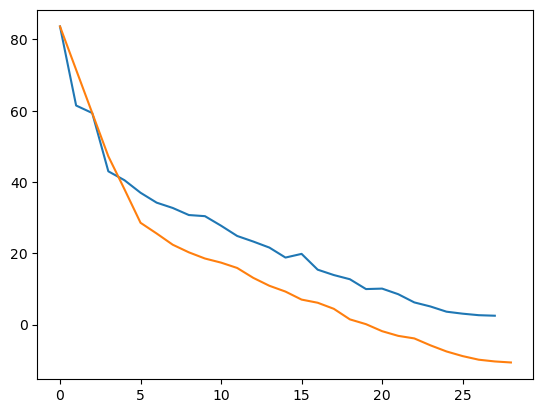

In [16]:
# find minimum from channel center
xs_mins = xs_levee_smooth.loc[3100:3300].min(axis=0)
xs_mins.index = xs_mins.index.astype(int)
# xs_mins.interpolate(method='linear').plot()
slope = xs_mins.diff().rolling(2, center=True, closed='right').mean().bfill()/2000*-1
adj_xs_mins = np.append(xs_mins[0], (xs_mins[0]-slope.cumsum()*2000))

# (xs_mins.diff()/-2000).plot()
# slope.plot()
# plt.show()
xs_mins.plot()
plt.plot(adj_xs_mins)

In [24]:
# the minimum elevation for each subsegment applied outward across the transects
xs_mins_arr = np.loadtxt(chan_dir+'subsegments_xs_mins.tsv', delimiter='\t')
# need to correct segment definition to where the xs_mins subsegment data is
xs_arr[np.isnan(xs_mins_arr)] = np.nan

In [17]:
# rating curves for each segment and setback
xs_flow_all = pd.read_csv(join(chan_dir,'all_xs_50pt_rating_curves.csv'))

def depth_match(seg_flow, flow):
    """ Given a XS (nseg, setback) return the expected depth (m) given a flow (cms)"""
    # find flows above and below the input flow
    flow_diff = (seg_flow.flow_cms-flow)
    f_high = flow_diff[flow_diff>0].argsort().index[0]
    f_low = flow_diff[flow_diff<0].argsort().index[-1]
    match_d = seg_flow.loc[[f_low, f_high]].sort_values('flow_cms')
    # linearly interpolate to calculate exact depth
    flow_slope = (match_d.iloc[1].flow_cms-match_d.iloc[0].flow_cms)/(match_d.iloc[1].depth_m-match_d.iloc[0].depth_m)
    out_depth = match_d.iloc[0].depth_m + (flow-match_d.iloc[0].flow_cms)/flow_slope
    return(out_depth)

In [18]:
nseg = 10
setback=3200
seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
# seg_flow
depth_match(seg_flow, flow=500)

1.814347802070308

Text(0, 0.5, 'Flow ($m^3/s$)')

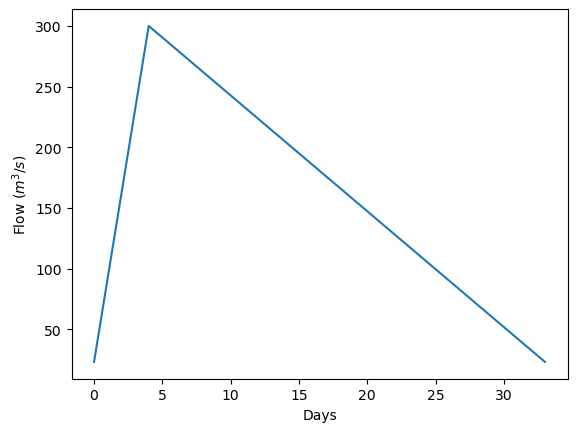

In [20]:
# for n in flood_type.index:
# 1, 2, 3 are floods long enough to apply to analysis
ft=2
# typical winter baseflow, peak flow, peak location, total time (days)
# flow of 23 m3/s listed by Whipple as floodplain cutoff
q_base = 23 # 200*(0.3048**3)
q_peak = flood_type.loc[ft,'cms_pk']
# total duration in days 
T = int(10**flood_type.loc[ft,'log_no_d'])
p_l = flood_type.loc[ft,'pk_loc']
tp = int(p_l*T)

q_rise = np.linspace(q_base, q_peak, tp)
q_fall = np.linspace(q_peak, q_base, (T-tp+1))
q_in = np.append(q_rise, q_fall[1:])
plt.plot(q_in)
plt.xlabel('Days')
plt.ylabel('Flow ($m^3/s$)')

# Flow loss procedure
1. Allocate arrays for:  
    1. flow (n realizations, n setbacks, n segments +1)  
    2. depth (n setbacks, nrow, ncol)  
    3. water surface elevation (n setbacks, nrow, ncol)  
    4. recharge (n realizations, n setbacks, nrow, ncol)  
2. Primary iteration:  
    1. Given a cross-section with a specified width for a given setback  
    2. Calculate the depth in the channel from the flow with Manning Equation  
    3. Add depth to cross-section minimum elevation to calculate water surface elevation for the given setback and segment  
3. Secondary Iteration:  
    1. Given a segment identify which cells have a water surface elevation above ground surface (i.e., inundated)  
    2. Calculate recharge based on inundated area, hydraulic gradient due to flood depth and vertical conductivity  
    3. Sum of recharge by segment  
    4. Calculate flow leaving the segment by subtracting recharge from flow entering the segment  
4. Optional Iteration:
    1. Apply a sequence of flows that include the rising limb and falling limb in addition to the peak flow
    2. Calculate total recharge from this continuous event
5. Outermost Iteration:  
    Complete these depth, recharge, flow calculations for each subsurface realization  
    

In [18]:
from scipy.optimize import minimize_scalar

# depths = np.zeros((len(setbacks), xs_levee_smooth.shape[1]))
Q = np.zeros((100, len(setbacks), xs_levee_smooth.shape[1]+1))
Q[:,:,0] = Q_cms
# save depth arrays for each setbacks
d_arr = np.zeros((len(setbacks), nrow, ncol))
wse_arr = np.zeros((len(setbacks), nrow, ncol))
# save high recharge flows
rch_hf_arr = np.zeros((100, len(setbacks), nrow, ncol))




Rather than focusing on improving the solver iteration which isn't that bad (21 iterations isn't great but it could be worse), I should work on solution: updating roughness based on cross-section width, include levee wall roughness in wetted perimeter. Look at sensitivity of vertical conductivity. Summarize recharge by time period of flood (travel time is 13.2 hours/45 km per Whipple, about 0.3 hrs per 1 km) which is about 0.6 hrs per 2km to multiply by the recharge rate.   
The current set up with a flow minus recharge makes sense if we assume a temporary steady state is reached (true for sub half hour), but if I want to start calculating volumes for transient events then I need to account for the duration.

Whipple notes a floodplain inundation threshold of 23 m3/s at MHB where the lowest lying floodplain areas connect.

In [ ]:
# using rating curve method with linear interpolation is 15x faster than minimize scalar

In [50]:
# runs a singular flow value
from time import time
# takes ~45 minutes
t=0
tic = time()
n = 0.048 # assume constant roughness for now

for t in np.arange(0,1):
    # iterate across all cross-sections
    for nseg in np.arange(0,xs_levee_smooth.shape[1]):
        # iterate across all setbacks
        for s,setback in enumerate(setbacks):
            # for a given setback imagine there is an impenetrable levee blocking overbank flow
#             xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
            xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg], setback)
            # solve for depth that matches given flow
            if Q[t, s,nseg] >0:
                res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[t, s,nseg]), bounds=(0,10), method='bounded')
                depth = res.x
#                 seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
#                 depth = depth_match(seg_flow, flow=Q[t, s,nseg])
            else:
                depth = 0
            # join depth calculated at cross-section to corresponding model cells and corresponding setback
#             wse_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth + xs_elevs.min()
#             d_arr[s,(xs_arr==nseg)&(str_setbacks <= s+1)] = depth
            wse_arr[s,(xs_arr==nseg)&(str_setbacks[s]==1)] = depth + xs_elevs.min()
            d_arr[s,(xs_arr==nseg)&(str_setbacks[s]==1)] = depth 
        # identify wse above surface elevation 
        d_arr = d_arr* (wse_arr > dem_data)
        # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
        # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
        rch_hf_arr[t,:,:,:] += (xs_arr==nseg)*(soil_K[t,:,:])*hf_tot[t,:,:] *(200*200)*((d_arr* + soil_thick)/soil_thick)
        Q[t, :, nseg+1] = Q[t, :, nseg] - np.nansum(rch_hf_arr[t,:, xs_arr==nseg], axis=(0))
        
toc = time()
print((toc-tic)/3600)

0.003779599799050225


In [28]:
from time import time
from scipy.optimize import minimize_scalar



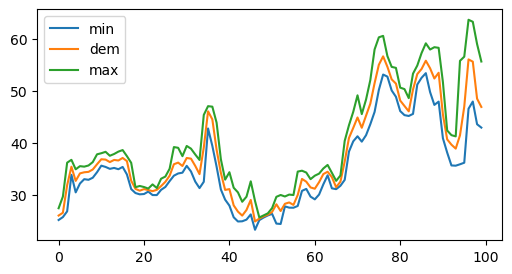

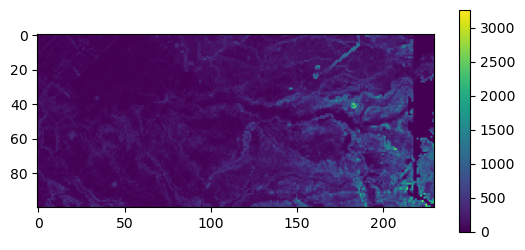

In [29]:
# find difference between water surface and cell elevations
diff = wse_arr[tp-1,-1,:] - arr_elev
diff[diff<0] = np.nan
# find the highest elevation above which there is water
bot_q = np.argmin(diff, axis=0)[rows,cols] - 1
bot_q[bot_q<0] = 0
top_q = np.argmin(diff, axis=0)[rows,cols] 
# find percentage of interim quantile
perc_q = (dem_data[rows,cols] - arr_elev[bot_q, rows,cols])/(arr_elev[top_q, rows,cols] +1E-3 - arr_elev[bot_q, rows,cols])
# percent of cell area covered by flood
perc_A = np.reshape(bot_q + perc_q, (nrow,ncol))/10

fig,ax = plt.subplots(figsize=(6,3))
n = 150
ax.plot(arr_elev[0][:,n], label='min')
ax.plot(dem_data[:,n], label='dem')
ax.plot(arr_elev[10][:,n], label='max')
ax.legend()
fig,ax=plt.subplots()
ax.imshow(perc_A)
plt.colorbar(ax.images[0], shrink=0.6)


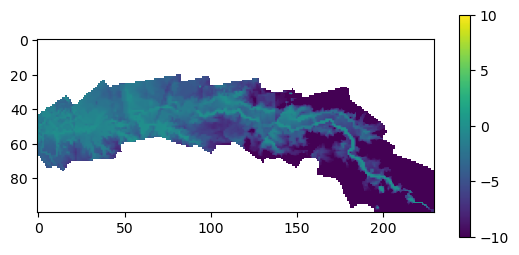

In [31]:
plt.imshow(xs_mins_arr - arr_elev[0],vmin=-10, vmax=10)
plt.colorbar(shrink=0.6)

In [ ]:
# wse_temp = np.zeros((nrow,ncol))
# nseg = 27
# s=0
# depth = 1
# for s in np.arange(0,17):
#     for nseg in [27]:#np.arange(0,27):
#         fp_zon = (xs_arr==nseg)&(str_setbacks[s]==1)
# #         wse_temp[fp_zon] = depth + xs_mins_arr[fp_zon]
# #         if any(np.isnan(xs_mins_arr[fp_zon])):
# #             print('Seg',str(nseg),'Setback',str(s), xs_mins_arr[fp_zon])
# #         # calculate depth of water at different elevation percentiles for segment and setback
# #         diff = wse_temp*fp_zon - arr_elev
# #         # when depth is negative remove
# #         diff[diff<0] = 0 #np.NaN
# #         # only keep cells where water level is above lowest elevation
# #         diffmax = np.nanmax(diff, axis=0)
#         print(np.nanmax(xs_mins_arr[fp_zon]))

In [21]:
def arr_to_h5(Q, rch_hf_arr, d_arr, h5_fn):
    # convert arrays of annual rates to hdf5 files individually
    f = h5py.File(h5_fn, "w")
    grp = f.require_group('array') # makes sure group exists
    grp.attrs['units'] = 'cubic meters/second'
    grp.attrs['description'] = 'Each layer of the array is a day in the event'
    dset = grp.require_dataset('flow', Q.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = Q
    dset = grp.require_dataset('rch_hf', rch_hf_arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = rch_hf_arr
    dset = grp.require_dataset('depth', d_arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = d_arr
    f.close()
    


In [26]:

def realization_recharge(t, str_setbacks, region):
    # allocate arrays - num flow steps, num setbacks, num segments
    Q = np.zeros((q_in.shape[0], len(setbacks), xs_levee_smooth.shape[1]+1))
    # set inflow for segment 1 across all setbacks and for all times
    # rate of cubic meters per second
    Q[:,:,0] = np.repeat(q_in.reshape(-1,1), len(setbacks), axis=1)
    # save depth arrays for each setbacks
    d_arr = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))
    wse_arr = np.zeros((len(setbacks), nrow, ncol))
    cell_frac = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))
    # save high recharge flows
    rch_hf_arr = np.zeros((q_in.shape[0], len(setbacks), nrow, ncol))

    tic = time()
    n = 0.048 # assume constant roughness for now

    # iterate across streamflows
    for qn in np.arange(0, q_in.shape[0]):
        # iterate across all cross-sections
        for nseg in np.arange(0,xs_levee_smooth.shape[1]):
            # iterate across all setbacks
            for s,setback in enumerate(setbacks):
                # for a given setback imagine there is an impenetrable levee blocking overbank flow
    #             xs_elevs = xs_levee_smooth.iloc[:,nseg][3100-setback:3300+setback]
                xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg], setback)
                # boolean of row,col cells that fall within the segment and setback
#                 fp_zon = (xs_arr==nseg)&(str_setbacks <= s+1)
                fp_zon = (xs_arr==nseg)&(str_setbacks[s]==1)
                # solve for depth that matches given flow, assume less than 1 cms is too small to calculate
                if Q[qn, s,nseg] >1:
                    # solve for depth that matches given flow
#                     res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[qn, s,nseg]), 
#                                               method='Golden', tol=1E-3)
#                     # if large flow error, likely stuck in local minimum try setting higher or lower
#                     if mannings(res.x, xs_elevs, n, slope.iloc[nseg]) > Q[qn, s,nseg]*1.05:
#                         res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[qn, s,nseg]), 
#                                       bounds=(1E-3,res.x-0.1), method='bounded')
#                     if mannings(res.x, xs_elevs, n, slope.iloc[nseg]) < Q[qn, s,nseg]*0.95:
#                         res = minimize_scalar(min_Q, args = (xs_elevs, n, slope.iloc[nseg], Q[qn, s,nseg]), 
#                                       bounds=(res.x+0.1,10), method='bounded')
#                     if res.fun>0.05*Q[qn, s,nseg]: # greater than 5% difference try to fix with bounded solving
#                         print(str(nseg),' ', s, '%.2f'%res.fun, 'iter %i'%res.nit, ', ',res.success, 'd %.2f'%res.x)
#                     depth = np.copy(res.x)
                    seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
                    depth = depth_match(seg_flow, flow=Q[qn, s, nseg])
                else:
                    depth = 0
                # join depth calculated at cross-section to corresponding model cells and corresponding setback
                # add elevation to minimum to apply segment midpoint as elevation rather than lowest point
#                 wse_arr[s, fp_zon] = depth + xs_elevs.min() + slope.iloc[nseg]*1000
                wse_arr[s, fp_zon] = depth + xs_mins_arr[fp_zon]
#                 if any(np.isnan(xs_mins_arr[fp_zon])):
#                     print('Seg',str(nseg),'Setback',str(s), xs_mins_arr[fp_zon])
                # calculate depth of water at different elevation percentiles for segment and setback
                diff = wse_arr[s,:]*fp_zon - arr_elev
                # when depth is negative remove
                diff[diff<0] = 0 #np.NaN
                # only keep cells where water level is above lowest elevation
                diffmax = np.nanmax(diff, axis=0)
                # keep cells where diffmax >0 
                x,y = np.where(diffmax>0)
                # find the highest elevation above which there is water, subtract 1 uses lower percentile
                # where the wse was below the minimum ignore
                bot_q = np.argmin(diff, axis=0)[x,y] - 1
                bot_q[bot_q<0] = 0
                top_q = np.argmin(diff, axis=0)[x,y]
                # find percentage of interim quantile
                perc_q = (wse_arr[s, x,y] - arr_elev[bot_q, x,y])/(arr_elev[top_q, x,y] +1E-3 - arr_elev[bot_q, x,y])
                # percent of cell area covered by flood
                cell_frac[qn, s,x,y] = (bot_q + perc_q)/10
                # depth for each cell is difference between water surface and average flooded ground elevation
                d_arr[qn, s,fp_zon] = np.nanmean(diff, axis=0)[fp_zon] #depth 
                # identify wse above surface elevation 
#                 d_arr[qn,:] = d_arr[qn,:] * cell_frac[qn] # caused overflow error
            # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
            # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
            q_seep = (soil_K[t,:,:])*hf_tot[t,:,:]*(200*200)*((d_arr[qn,:] + soil_thick)/soil_thick)
            rch_hf_arr[qn,:,:,:] += (xs_arr==nseg) * q_seep * cell_frac[qn]
            # identify when the flow is less than the recharge predicted and recharge > 0 
            dry = (Q[qn, :, nseg] < np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)) & (np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)>0)
            if any(dry):
                # where the cells will end dry, reduce recharge so it sums to the flow into segment
    #             scale = (Q[qn, :, nseg][dry]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))[dry])
                scale = (Q[qn, :, nseg]/(np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0)))) 
                scale = np.where(scale > 1, 1,scale) # only scale when flow is less than recharge
#             if any(scale<1):
#                 rch_hf_arr[qn, :,xs_arr==nseg][:,dry] *= scale
                rch_hf_arr[qn, :,xs_arr==nseg] *= scale
                print('scale', np.round(np.median(scale),2))
            Q[qn, :, nseg+1] = Q[qn, :, nseg] - np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))
            if any(Q[qn,:,nseg+1]<0):
                print(qn, nseg+1)
                
    
    base_fn = join(data_dir, region, 'type'+str(ft), 'r'+str(t).zfill(3)+'_')
    arr_to_h5(Q, rch_hf_arr, d_arr, base_fn+'output.hdf5')
    # saving all of the flow at all steps, setbacks is needed to post-process
#     Q_out = np.reshape(Q, ((q_in.shape[0]*len(setbacks), xs_levee_smooth.shape[1]+1)))
#     np.savetxt(base_fn+'flow.tsv', Q_out)
    # for recharge we want to aggregate across time steps but look at differences across setbacks
#     rch_out = np.reshape(np.nansum(rch_hf_arr, axis=0), (len(setbacks)*nrow, ncol))
#     np.savetxt(base_fn+'recharge.tsv', rch_out)
    toc = time()
    print((toc-tic)/3600)
    return(Q, rch_hf_arr, d_arr, cell_frac)


In [20]:
# all 84 steps should only take 1 second
(.0002*84)*60
# flow_type

1.0080000000000002

In [129]:
# n = 0.048
# nseg=13
# s=7
# setback = setbacks[s]

# xs_elevs = xs_setback(xs_levee_smooth.iloc[:,nseg].copy(), setback)
# Q_chk = mannings(3.03, xs_elevs, n, slope.iloc[nseg])
# print('Q calc %.2f' %Q_chk, 'Q in %.2f' %Q[qn,s,nseg])


Q calc 126.94 Q in 114.05


In [378]:

# check why the addition of dry segment check didn't fix negative flows
qn = 0
nseg = 24

# identify when the flow is less than the recharge predicted and recharge > 0
dry = (Q[qn, :, nseg] < np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)) & (np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0)>0)
# where the cells will end dry, reduce recharge so it sums to the flow into segment
# scale = (Q[qn, :, nseg][dry]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))[dry])
if any(dry):
    print('Recharge exceeds flow')
print('Flow nseg -1   ',np.round(Q[qn, :, nseg-1],2))
print('Recharge nseg-1',np.round(np.nansum(rch_hf_arr[qn,:, xs_arr==nseg-1], axis=0),2))
# the flow into the next segment isn't equally the flow in the previous minus recharge with the dry adjustment
print('Flow nseg     ',np.round(Q[qn, :, nseg],2))
print('Recharge nseg  ',np.round(np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=0),2))

# even though flow is negative there is somehow depth at these locations
print('Depth nseg    ',np.round(np.nanmax(d_arr[qn,:,xs_arr==nseg], axis=0),2))
# this may be an issue with how the minimum XS elevation is defined, bascially the min XS value should be consistent
print('Flow nseg +1  ', np.round(Q[qn, :, nseg+1],2))
# once flow hits negative then there is no longer depth so no more recharge at least
# when flow is less than recharge and greater than 0 then scaling is appropriate
# I'm get at least a couple of NAs in the scaling which will cause issues

# if flow is already negative then this scaling function does not help, it would be adding flow from recharge which is wrong
# scale = (Q[qn, :, nseg][dry]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0))[dry])
scale = (Q[qn, :, nseg]/np.nansum(rch_hf_arr[qn,:, xs_arr==nseg], axis=(0)))
scale = np.where(scale > 1, 1,scale)
print('Scale nseg     ', scale)

Recharge exceeds flow
Flow nseg -1    [22.19 22.26 22.08 21.96 21.81 21.68 20.5  20.27 20.2  20.21 20.07 20.06
 20.08 20.08 20.08 19.32 19.15]
Recharge nseg-1 [0.   0.96 1.17 2.54 2.53 2.78 1.65 1.47 1.59 1.59 0.99 0.99 0.99 0.99
 0.94 0.93 0.93]
Flow nseg      [22.19 21.3  20.91 19.43 19.28 18.89 18.84 18.79 18.61 18.63 19.08 19.07
 19.1  19.1  19.14 18.39 18.22]
Recharge nseg   [ 0.25  0.21 24.4  48.95 43.37 43.12 49.   49.45 49.16 49.21 48.67 41.25
 41.8  42.28 42.43 42.05 41.94]
Depth nseg     [0.31 0.25 1.84 1.8  1.54 1.53 1.64 1.66 1.65 1.65 1.63 1.44 1.44 1.44
 1.44 1.43 1.42]
Flow nseg +1   [ 21.94  21.1   -3.5  -29.52 -24.1  -24.23 -30.15 -30.66 -30.55 -30.59
 -29.59 -22.17 -22.71 -23.18 -23.29 -23.67 -23.72]
Scale nseg      [1.         1.         0.8567445  0.39689055 0.444413   0.43807569
 0.38459889 0.38005658 0.37850387 0.37844615 0.39207704 0.46241291
 0.45680006 0.4516957  0.45107897 0.43726007 0.43442337]


# Run code

In [27]:
# a couple realizations failed to write output including 48
t=5
Q, rch_hf_arr, d_arr, cell_frac = realization_recharge(t, str_setbacks, 'regional')



scale 1.0
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
scale 1.0
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
scale 1.0
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
scale 1.0
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
scale 1.0
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
scale 1.0
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
scale 1.0
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
6 28
scale 1.0
7 20
7 21
7 22
7 23
7 24
7 25
7 26
7 27
7 28
scale 1.0
8 20
8 21
8 22
8 23
8 24
8 25
8 26
8 27
8 28
scale 1.0
9 20
9 21
9 22
9 23
9 24
9 25
9 26
9 27
9 28
scale 1.0
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
scale 1.0
11 20
11 21
11 22
11 23
11 24
11 25
11 26
11 27
11 28
scale 1.0
12 20
12 21
12 22
12 23
12 24
12 25
12 26
12 27
12 28
scale 1.0
13 20
13 21
13 22
13 23
13 24
13 25
13 26
13 27
13 28
scale 1.0
14 20
14 21
14 22
14 23
14 24
14 25
14 26
14 27
14 28
scale 1.0
15 20
15 21
15 22
15 23
15 24
15 25
15 26
15 27
15 28
scale 1.0
16 20
16 21
16 22
16 23
16 24
16 25
16 26
16 27
16 28
sc

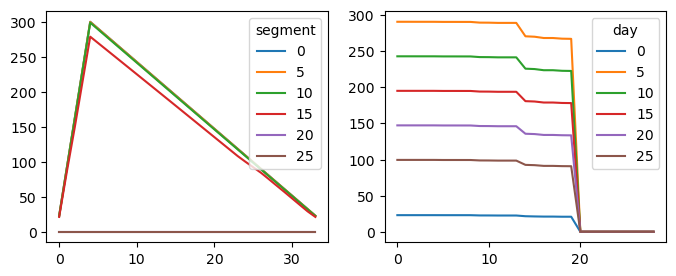

In [28]:
fig,ax = plt.subplots(1,2, figsize=(8,3))# time series
# select segments all times
for n in [0,5, 10,15,20,25]:
    ax[0].plot(Q[:,-1,n], label=n)
ax[0].legend(title='segment')
# plt.show()
# first time all segs
# longitudinal losses
for n in [0,5, 10,15,20,25]:
    ax[1].plot(Q[n,-1, :],label=n)
ax[1].legend(title='day')
# rch_hf_arr.sum(axis=(2,3))[:,-1]

In [29]:
# calculate recharge for each flow and setback, daily average in m3/s
rch_q_sum = pd.DataFrame(np.sum(rch_hf_arr, axis=(2,3)), columns= setbacks).transpose()
# calculate sum for all flows (daily average)
rch_sum = rch_q_sum.sum(axis=1)
# convert to AF/day and will have the total AF recharged because already summed by day
rch_sum_AF = rch_sum*86400/((0.3048**3)*43560)

# if we divide by the setback area we will get the depth of recharge per setback area
setback_area = [np.sum(str_setbacks[s]== s)*200*200 for s in np.arange(0,len(setbacks)) ]

# (rch_sum_AF/setback_area).plot()

In [73]:
# tp = 5
# s = 5
# fig,ax=plt.subplots(1,2,figsize=(8,4))
# for s in [0,5,10,15]:
#     temp = np.zeros(xs_levee_smooth.shape[1])
#     for nseg in np.arange(0,xs_levee_smooth.shape[1]):
# #         temp[nseg] = np.nanmean(wse_arr[tp,s][xs_arr==nseg])
#         temp[nseg] = np.nanmean(d_arr[tp,s][xs_arr==nseg])
# #     ax[1].plot(temp)
#     ax[1].plot(xs_levee_smooth.min().values,label=s)
#     ax[0].plot(temp,label=s)
    
    
# plt.legend()

In [74]:
# tp = 5
# s = 5
# temp = np.zeros(xs_levee_smooth.shape[1])
# for nseg in np.arange(0,xs_levee_smooth.shape[1]):
#     temp[nseg] = np.nanmean(wse_arr[tp,s][xs_arr==nseg])
# plt.plot(temp, label='WSE')
# xs_levee_smooth.min().plot(label='Channel Bottom')
# plt.legend()

In [30]:
colors = ['lightgray', 'blue']
scale = [0, 1]
cmap=mpl.colors.ListedColormap(colors)
norm=mpl.colors.BoundaryNorm(scale, len(colors))


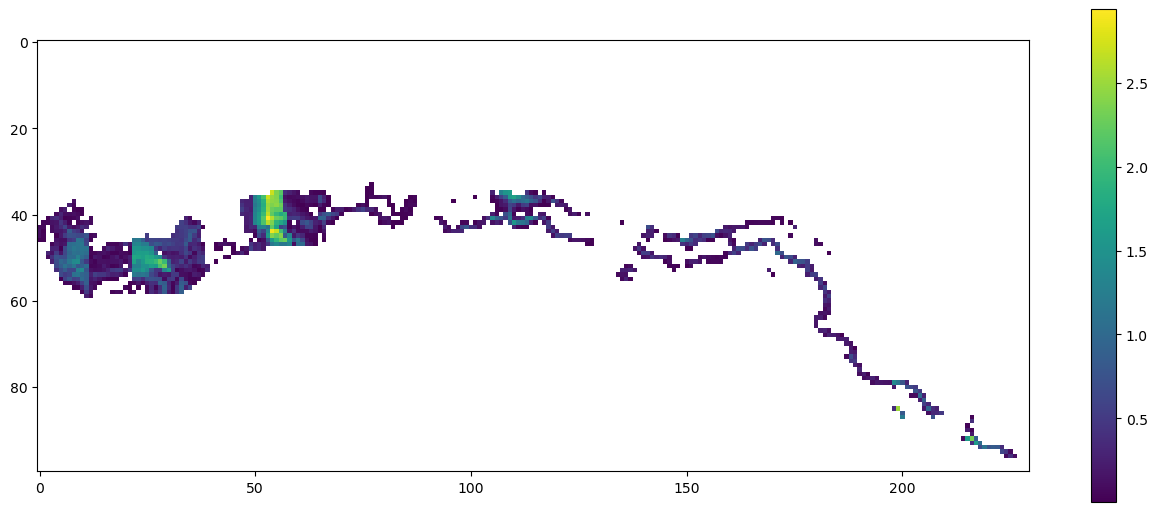

In [31]:
# masking inactive to try to improve mapping
d_mask = ma.masked_where(d_arr==0, d_arr )

s = 6
fig, ax = plt.subplots(figsize=(16,16))
# ax.imshow(d_mask[0,16])
im=ax.imshow(d_mask[tp,s])
plt.colorbar(im, shrink=0.4)

In [49]:
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
sfr_union = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_sfr.unary_union], crs=grid_sfr.crs)
sfr_union.geometry = sfr_union.buffer(setback).exterior
# sfr_union.plot(color="None", edgecolor='black',ax=ax_n, linewidth = 0.2)

In [41]:
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [59]:
setback_grid = gpd.sjoin(sfr_union, grid_p, how='left')
setback_outer = np.zeros((nrow,ncol))
setback_outer[setback_grid.row-1, setback_grid.column-1] = 1
setback_outer = ma.masked_where(setback_outer==0,setback_outer)

[]

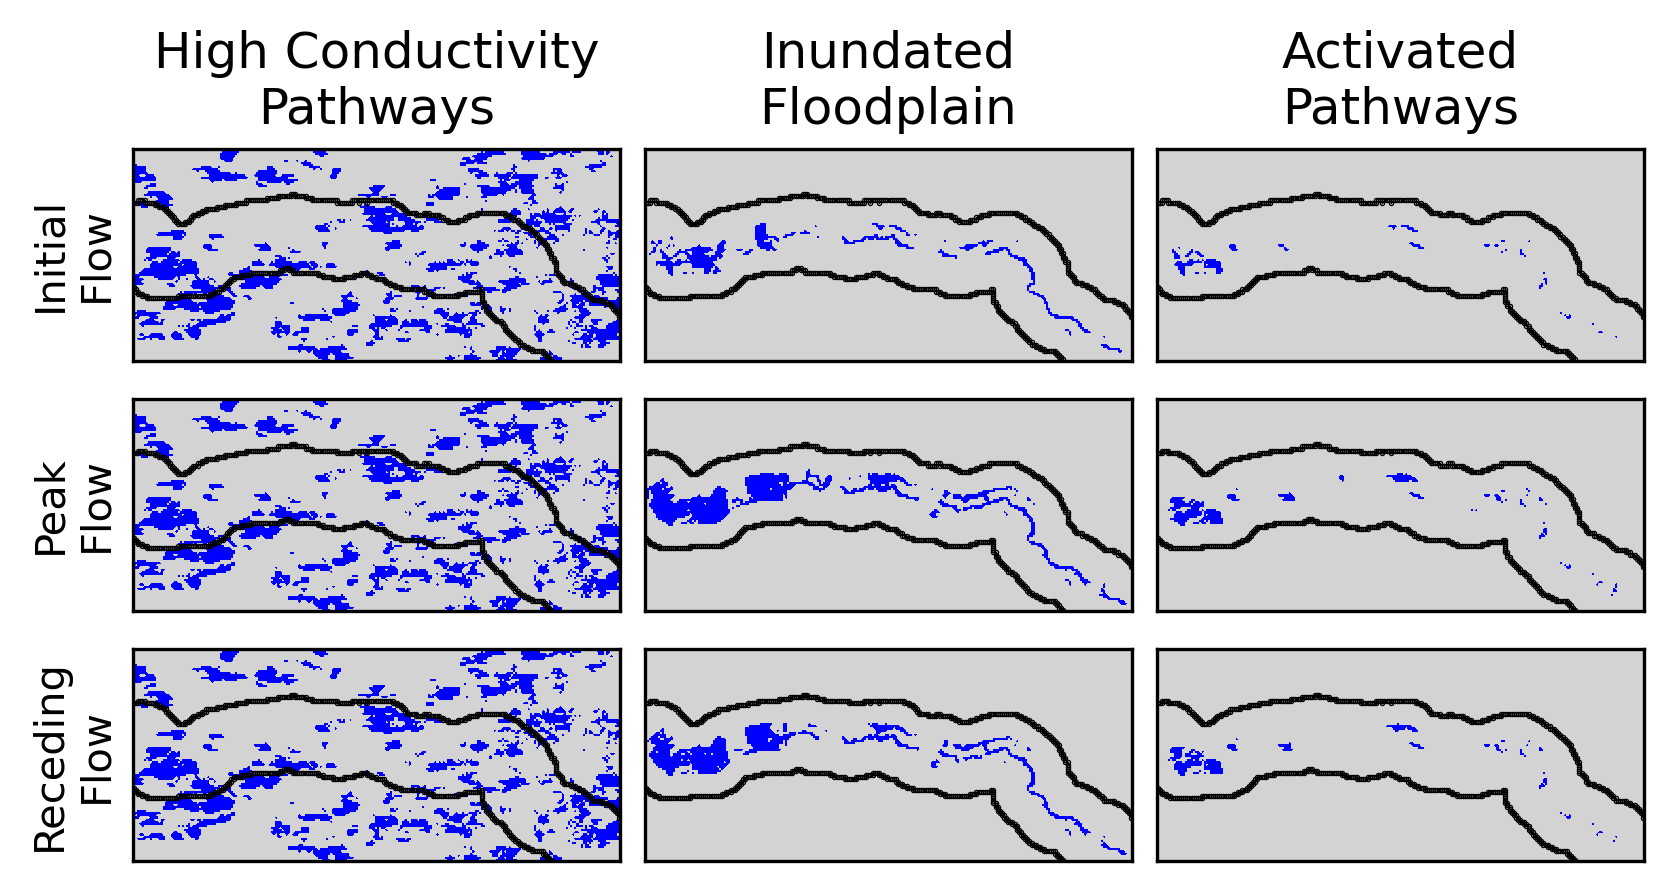

In [80]:

# show change in activated pathways by either setback distance impact on flooded area or
# flood flow impact
fig,ax=plt.subplots(3,3, figsize=(6.5, 6.5), sharex=True, sharey=True, dpi=300)
# fig.tight_layout(hspsace=0.2, wspace=0.2)
plt.subplots_adjust(hspace=-0.75, wspace=0.05)

s=6
# initial, peak, half way receded
for i,qn in enumerate([0, tp, int(tp+(T-tp)/2)]):
#     ax[i,0].imshow(hf_tot[t])
    im = ax[i,0].imshow(hf_tot[t],cmap=cmap)

    ax[i,1].imshow(d_arr[qn,s,:]>0, cmap=cmap)
#     ax[i,1].imshow(d_mask[qn,s,:])

    ax[i,2].imshow(rch_hf_arr[qn,s,:]>0, cmap=cmap)
    for n in np.arange(0,3):
        ax[i,n].scatter(setback_grid.column-1, setback_grid.row-1, color='black', s=0.1)
    
# axis labels
ax[0,0].set_ylabel('Initial\nFlow')
ax[1,0].set_ylabel('Peak\nFlow')
ax[2,0].set_ylabel('Receding\nFlow')

# color bar on all rows, with two discrete labels
# cbar=plt.colorbar(mappable = im, ax=ax[2,0],  ticks = [0.25,.75], shrink= 0.7, orientation='horizontal')
# cbar.ax.set_yticklabels(['Low flow facies', 'High flow facies'])

# titles
ax[0,0].set_title('High Conductivity\nPathways')
ax[0,1].set_title('Inundated\nFloodplain')
ax[0,2].set_title('Activated\nPathways')

plt.setp(ax, xticks=[], yticks=[])


In [468]:
# fig,ax = plt.subplots(3,1,figsize=(8,8), sharex=True)
# # plot baseflow
# Q_plt = pd.DataFrame(Q[0,:,:], index=setbacks, columns = np.arange(0,(num_segs+1)*2,2)).transpose()
# Q_plt.plot(color='lightgray', legend=False, ax=ax[0])

# # plot peak
# Q_plt = pd.DataFrame(Q[tp-1,:,:], index=setbacks, columns = np.arange(0,(num_segs+1)*2,2)).transpose()
# Q_plt.plot(color='lightgray', legend=False, ax=ax[1])

# # plot midway through recession
# Q_plt = pd.DataFrame(Q[tp-1+int((T-tp)/2),:,:], index=setbacks, columns = np.arange(0,(num_segs+1)*2,2)).transpose()
# Q_plt.plot(color='lightgray', legend=False, ax=ax[2])

# plt.xlabel('Distance downstream (km)')
# plt.ylabel('Discharge ($m^3/s$)')

In [522]:
# time for running 100 realizations in parallel
#4.8 hrs for type1, 17377/3600 (81 steps)
# 2.7 hrs for type2 (34 steps)
# 1.3 hrs for type3 (14 steps)

1.3325

## Streamflow data
Routing flow down channel: original intent was to focus on a few sizes of streamflows based on return periods (e.g., 5, 20 years) but I could run this every day with variable streamflow for the past 10 years to identify the number of days when floodplains are activated. The next level would be to run this with inundation maps for everyday.

Need to start with singular flow events to test the difficulty of running iterative flow with leakage dependent on flood depth and number of high flow cells. It's easy to think the work would be more interesting if everything was in a complex model but often the simpler more fundamental work is what is meaningful therefore I should work for parsimony by testing a singular flow and using a Darcy recharge before going more complex.

In [70]:
# Cosumnes River at Michigan Bar, daily flow cfs
# from 10/1/1983 to 10/1/2010
# inflow_15 = pd.read_csv('data\MI_bar_15min.csv', parse_dates = True, 
#                 index_col = 0, sep = ',', header = 'infer')

## Groundwater level data

## Muskingum Parameters 

K is the travel time for the river and $N_{steps}$ is the number of sub reaches so that the total travel time adds to K  
Value of X ranges from 0 for reservoir-type storage to 0.5 for a full wedge. When X = 0 there is no wedge so no backwater (e.g., level-pool reservoir). **In natural stream X is between 0 and 0.3 with a mean near 0.2.** Great accuracy is not needed due to insensitivity.  
US ACE (1990) criterion for number of routing reaches:
$$ \frac{1}{2(1-X)} \leq \frac{K}{N_{steps}\Delta t} \leq \frac{1}{2X} $$

In [261]:
N = len(xs_levee_smooth.columns)
rchlen = 2 # length of 2 km
# actual length of XS
L_XS = rchlen*N

# reaches every 1 km
L = 45 # kilomters
K = 13.2*(L_XS/L) # hourly
print('Travel time %.2f' %K ,' hours for %.1f' %L_XS,'km')

X = 0.1 # weighting between wedge and pool storage, 0 is pool, 0.5 for a full wedge
l = 1/(2*(1-X))
r = 1/(2*X)
# N = 62 # reaches of 1 km
delt = 0.5 # hours
m = K/(N*delt)

print('Reach travel time and acceptable range')
print('%.3f' %l,'<= %.3f' %m,'<= %.3f' %r)
K_rch = K/N # travel time for a reach of length total length/ number of reaches
# print('Max reach storage (ft^3/min):', Smax/K) # (ft^3/min)


Travel time 16.43  hours for 56.0 km
Reach travel time and acceptable range
0.556 <= 1.173 <= 5.000


With the given travel time for the lower Cosumnes River with 1 km length reaches requires 0.5 hourly steps and X = 0.1  
x is in the downstream longitudinal channel direction and y (stage) is in the vertical direction away from the streambed.  
Celerity equation:  
$$ c_k = \frac{dx}{dt} = \frac{dQ}{dA} = \frac{1}{B}\frac{dQ}{dy} $$

Muskingum Cunge
Variation of kinematic wave. Cunge (1969) showed when K and del t are constant it is an approximate solution of the kinematic wave. It can be considered an approxmiation of the a modified diffusion equation if 
$$ K = \frac{ \Delta X}{ c_k}  = \frac{\Delta X}{(dQ / dA )}  $$
OR $$ \Delta x = \frac{K}{c_k} $$
$$X = \frac{1}{2}(1-(\frac{Q}{B c_k S_o\Delta X)}  $$

Froude Number, V = flow velocity, surface wave speed =  sqrt(g*y), g = gravity, y= depth:
$$ Fr = \frac{V}{\sqrt{gy} }$$
$$ Fr<1.0 subcritical flow $$ $$ Fr = 1.0 critical flow $$ $$Fr> 1.0 supercritical flow $$

In [ ]:
# froude number <1 subcritical, 1 citical, >1 super critical
# V = flow velocity, surface wave speed =  sqrt(g*y), g = gravity, y= depth
# Fr = V/npsqrt(9.81*y)

Text(0, 0.5, 'Flow ($m^3/s$)')

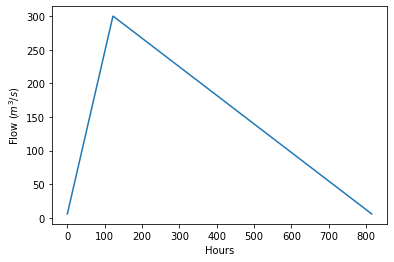

In [264]:
# for n in flood_type.index:
# 1, 2, 3 are floods long enough to apply to analysis
n=2
# typical winter baseflow, peak flow, peak location, total time (days)
q_base = 200*(0.3048**3)
q_peak = flood_type.loc[n,'cms_pk']
# total duration in days 
T = int(10**flood_type.loc[n,'log_no_d'])*24
p_l = flood_type.loc[n,'pk_loc']
tp = int(p_l*T)

q_rise = np.linspace(q_base, q_peak, tp)
q_fall = np.linspace(q_peak, q_base, (T-tp))
q_in = np.append(q_rise, q_fall)
plt.plot(q_in)
plt.xlabel('Hours')
plt.ylabel('Flow ($m^3/s$)')

In [150]:


# toc = time()
# print(np.round(toc-tic,2))
folder = '/r' + str(t).zfill(3)+'/'
folder
# np.savetxt(basedir+folder+'rch_hf_arr_cms.tsv', np.reshape(rch_hf_arr, (len(setbacks)*nrow,ncol)), delim='\t')
# np.savetxt(basedir+folder+'Q_cms.tsv', Q, delim='\t')


'r000'

In [169]:

def Adj_Muskingum(I, XS, K, X, slope, hf_tot, soil_K, soil_thick, xs_arr):
    """ 
    Given an upstream inflow route flow downstream with Muskingum and adjust for recharge losses to groundwater
    assuming losing system
    Input:
    I = Inflow at uppermost reach
    XS = XS data for all stream segments, dim = (XS distances, No. stream segments)
    K = Muskingum travel time
    X = Muskingum storage weighting (0 = none, 0.5 = reservoir)
    soil_K = streambed hydraulic conductivity, dim = (NROW, NCOL)
    soil_thick = streambed thickness, dim = (NROW, NCOL)
    xs_arr = relates array location to stream segment, dim = (NROW,NCOL)
    
    Output:
    Q = discharge for each segment
    S = storage for each segment
    mb = mass balance error
    e = excess storage removed from channel
    swe = surface water elevation
    dh = hydraulic gradient between stream and groundwater
    qA = groundwater seepage from each segment
    rch_arr = array of groundwater recharge for model domain, dim = (NROW, NCOL, time)
    d_arr = array of flood depth for model domain, dim = (NROW, NCOL, time)
    """
    T = len(I)
    N = XS.shape[1]
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    swe = np.zeros(dim2)
    dh = np.zeros(dim2)
    qA = np.zeros(dim2)
    rch_arr = np.zeros((nrow, ncol, T))
    d_arr = np.zeros((nrow, ncol, T))
    wse_arr = np.zeros((nrow, ncol, T))

    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        for i in np.arange(0, N):
#         # solve for depth that matches given flow
            if Q[i,j] >0:
                d0 = [d_arr[(xs_arr==i), j-1].max()]
            # flow needs to be in cubic meters per second not hour for Manning
                res = minimize_scalar(min_Q, args = (XS.iloc[:,i], n, slope.iloc[i], Q[i, j]/(60*60)), 
                                      bounds=(0.1,10), method='bounded', tol=1E-3) 
                depth = res.x #[0]
            else:
                depth = 0
    #         # join depth calculated at cross-section to corresponding model cells and corresponding setback
            wse_arr[(xs_arr==i), j] = depth + XS.iloc[:,i].min()
            d_arr[(xs_arr==i), j] = depth 
            # identify wse above surface elevation 
            d_arr[(xs_arr==i), j] = d_arr[(xs_arr==i), j] * (wse_arr[(xs_arr==i), j] > dem_data[(xs_arr==i)])
            # update to allow for gw disconnection
    #         dh[:, j] =  (swe[:,j] - gwe)/(elev - gwe)
            # calculate vertical seepage with Darcy's equation assuming a saturated zone thickness similar to the lake bed in modflow
            # hydraulic conductivity is in m/s, hydraulic gradient is unitless, area is 200x200 m^2
            # need to convert HK from m/s to m/h
            rch_arr[:,:, j] += (xs_arr==i)*(soil_K*(60*60))*hf_tot *(200*200)*((d_arr[:,:,j] * + soil_thick)/soil_thick)
#             Q[i+1,j ] = Q[i, j] - np.nansum(rch_arr[xs_arr==i, j], axis=(1,2))
            # groundwater seepage term
#             q = k[i]*dh[i,j]*perimeter_base*rchlen # darcian groundwater flow
            qA[i,j] = np.nansum(rch_arr[xs_arr==i, j], axis=(0)) 
            # calculate flow into next segment
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j] - qA[i,j], 0, 1E15)
            # calculate storage in stream channel
            S[i,j+1] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j]))
            
#         if current storage is greater than max
#             if S[i,j] > Smax:
#                 # calculate the excess storage
#                 e[i,j] = S[i,j] - Smax
#                 # remove the excess storage from the outflow because it
#                 # is considered overbank flow
#                 Q[i,j] = Q[i,j] - e[i,j]/(K*(1-X))
#                 # reduce storage by amount that went overbank
#                 S[i,j] = S[i,j] - e[i,j]
                
            # mass balance check
            mb[i,j] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j])) - S[i,j+1]
#         swe[:, j+1] = np.linspace(TWC_stage(Q[i+1,j+1]), MB_stage(Q[i+1,j+1]), 48)
#         dh[:, j+1] =  swe[:,j+1] - gwe[:,j+1]
    return(Q, S, rch_arr, d_arr, qA, mb)

In [200]:
# i=0
# setback=200
# # xs_elevs.iloc[:,9].plot()
# xs_levee_smooth.loc[3100-setback:3300+setback,:].iloc[:,1].plot()

In [170]:
# I = inflow_15_reg.Discharge_cfs.values
# need to convert to cfm from cfs
# I0 = I*60
# need to convert from cms to cmh
Q0= q_in*60*60

r=0
setback = 0
n = 0.048 # assume constant roughness for now

# takes 23 minutes to run about 1E3 time steps for 1 realization
t1 = datetime.now()
xs_elevs = xs_levee_smooth.loc[3100-setback:3300+setback,:]

tQ, tS, rch_arr, d_arr, qA, mb = Adj_Muskingum(Q0, xs_elevs, K_rch, X, slope, hf_tot[r,:,:], soil_K[r,:,:], soil_thick, xs_arr)
t2 =  datetime.now()
print(t2-t1)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\scipy\optimize\_minimize.py:784: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
C:\Users\ajcalder\Documents\GitHub\CosumnesRiverRecharge/python_utilities\muskingum_recharge.py:80: RuntimeWarning: divide by zero encountered in double_scalars
  Q_calc = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))


0:22:22.933594


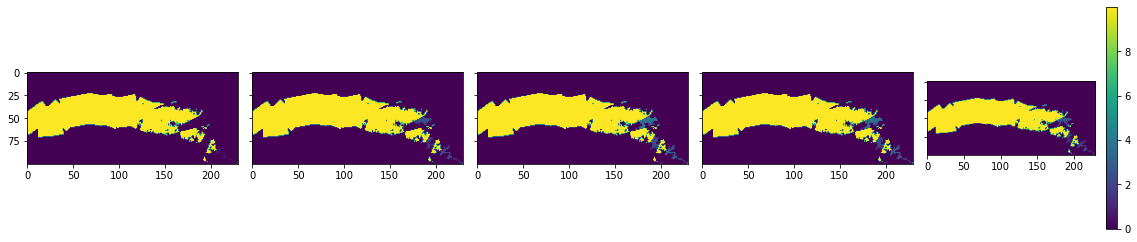

In [201]:

stps= [0, 60, 150, 250, 600]
fig,ax = plt.subplots(1,len(stps), sharex=True, sharey=True, figsize=(16,8))
for n, i in enumerate(stps):
#     im = ax[n].imshow(rch_arr[:,:,i])
    im = ax[n].imshow(d_arr[:,:,i])
fig.tight_layout()
fig.colorbar(im, shrink=0.4)

Travel time out 15.00 hours per km


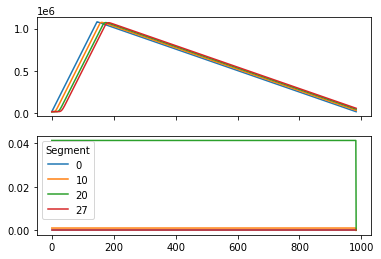

In [175]:
# the floodwave is moving too slowly
# it says it is traveling 10*2000 m in 600*0.5 hours
# and it should be about
print('Travel time out %.2f'%((600*0.5)/(10*2)), 'hours per km')
fig,ax = plt.subplots(2,1, sharex=True)
for i in [0,10,20,27]:
    ax[0].plot(tQ[i,:], label = str(i))
    ax[1].plot(qA[i,:], label = str(i))

plt.legend(title='Segment')
# plt.xlim([120,250])

Text(0, 0.5, 'Celerity')

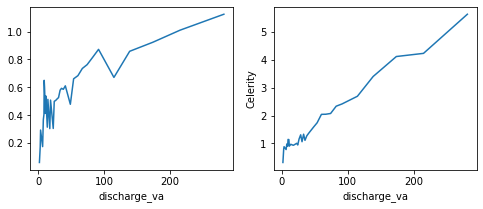

In [76]:
sfr_dir = gwfm_dir+'/SFR_data/'
# discharge is m3/day
mb = pd.read_csv(sfr_dir+ 'michigan_bar_icalc4_data.csv')
mb.discharge_va /= 86400

mb_diff = mb.diff(axis=0)
mb['ck'] = mb_diff.discharge_va/(mb_diff.gage_height_va * mb.chan_width )
mb['delX'] = K/mb.ck
mb['Fr'] = mb.discharge_va/(mb.gage_height_va *mb.chan_width)/ np.sqrt(mb_diff.gage_height_va * 9.80665 )

fig,axes=plt.subplots(1,2, figsize=(8,3))
mb.plot(x = 'discharge_va',y='Fr', label='Fr',legend=False, ax=axes[0])
ax.set_ylabel('Froude Number')
mb.plot(x = 'discharge_va',y='ck',  label='ck',legend=False, ax=axes[1])
axes[1].set_ylabel('Celerity')


In [119]:
def Muskingum(I, N, K, X):
    T = len(I)
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    
    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        for i in np.arange(0, N):
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j], 0, 1E15)
            
    return(Q)

## Muskingum Routing

## Distance and then time calculations

In [184]:
def Adj_Muskingum(I, N, K, X, k, gwe, elev):
    """ 
    Given an upstream inflow route flow downstream with Muskingum and adjust for recharge losses to groundwater
    assuming losing system
    Input:
    I = Inflow at uppermost reach
    N = number of segments
    K = Muskingum travel time
    X = Muskingum storage weighting (0 = none, 0.5 = reservoir)
    k = streambed hydraulic conductivity
    gwe = groundwater elevation
    elev = elevation of stream top for seepage calculation
    """
    T = len(I)
    # N rows and T columns
    dim = [N+1, T]
    dim2 = [N, T]
    Q = np.zeros(dim)
    S = np.zeros(dim2)
    mb = np.zeros(dim2)
    e = np.zeros(dim2)
    swe = np.zeros(dim2)
    dh = np.zeros(dim2)
    qA = np.zeros(dim2)
    
    Q[0,:] = I # set first row as historic inflow
    Q[1:,0] = Q[0,0] # assume initial inflow equals outflow all reaches
    S[:,0] = K*Q[1,0] # assume initial storage equals outflow because no wedge storage
    
    # Muskingum coefficients
    C1 = (delt - 2*K*X)/(2*K*(1-X)+delt)
    C2 = (delt + 2*K*X)/(2*K*(1-X)+delt)
    C3 = (2*K*(1-X)-delt)/(2*K*(1-X)+delt)
#     print('C1:', C1,'C2:', C2, 'C3:', C3)
    
    for j in range(0,T-1):
        # replace linear interpolation with Manning equation with XS data
        swe[:, j] = np.linspace(TWC_stage(Q[-1,j]), MB_stage(Q[0,j]), 48)+elev
        # update to allow for gw disconnection
        dh[:, j] =  (swe[:,j] - gwe)/(elev - gwe)
        for i in np.arange(0, N):
            # groundwater seepage term
            q = k[i]*dh[i,j] # darcian groundwater flow
            qA[i,j] = q*perimeter_base*rchlen # volumetric groundwater seepage
            Q[i+1,j+1] = np.clip(C1*Q[i,j+1] + C2*Q[i,j] + C3*Q[i+1,j] - qA[i,j], 0, 1E15)
            
            S[i,j+1] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j]))
            
#         if current storage is greater than max
#             if S[i,j] > Smax:
#                 # calculate the excess storage
#                 e[i,j] = S[i,j] - Smax
#                 # remove the excess storage from the outflow because it
#                 # is considered overbank flow
#                 Q[i,j] = Q[i,j] - e[i,j]/(K*(1-X))
#                 # reduce storage by amount that went overbank
#                 S[i,j] = S[i,j] - e[i,j]
                
            # mass balance check
            mb[i,j] = S[i,j] + K*(X*(Q[i,j+1]-Q[i,j])+(1-X)*(Q[i+1,j+1]-Q[i+1,j])) - S[i,j+1]
#         swe[:, j+1] = np.linspace(TWC_stage(Q[i+1,j+1]), MB_stage(Q[i+1,j+1]), 48)
#         dh[:, j+1] =  swe[:,j+1] - gwe[:,j+1]
    return(Q, S, e, mb)

In [185]:
# Flow statistics 
def stat(x):
    print('Min:', np.min(x), 'Max:', np.max(x), 'Mean:', np.mean(x))

# 15 minute discharge

In [186]:
# Run of adjusted Muskingum routing which gives outflow for all reaches

I = inflow_15_reg.Discharge_cfs.values
# need to convert to cfm from cfs
I0 = I*60

t1 = datetime.now()
tQ, tS, e, mb = Adj_Muskingum(I0, N, K, X, krch, gwe, elev)
t2 =  datetime.now()
print(t2-t1)



0:07:27.300214


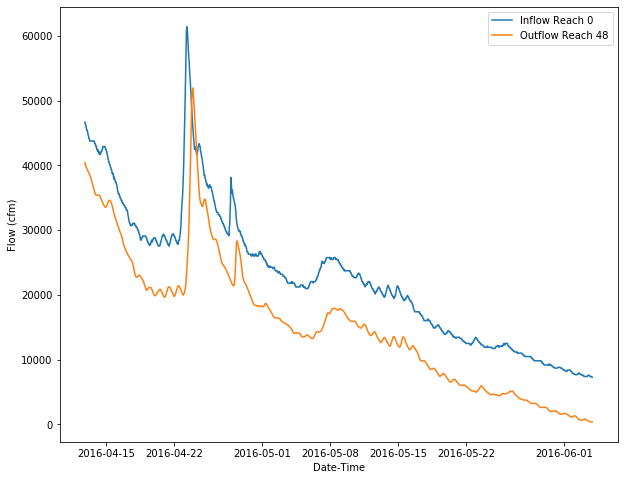

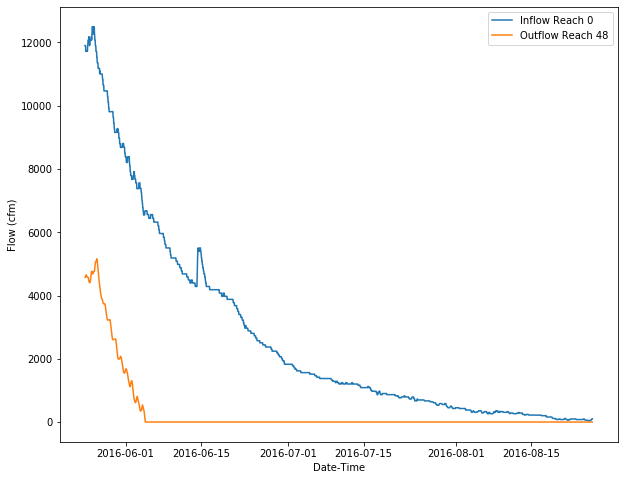

In [187]:
r = 47 # between 0 and 47
# between 0 and 200,000
outflow = pd.DataFrame(index = inflow_15_reg.index, data = np.transpose(tQ))
dt = np.arange(194000,199000)
plt.figure(figsize = (10,8))
plt.plot(outflow[1][dt])
plt.plot(outflow[48][dt])
plt.xlabel('Date-Time')
plt.ylabel('Flow (cfm)')
plt.legend(['Inflow Reach 0', 'Outflow Reach 48'])
plt.savefig('Routed_inflow_outflow_peaks', dpi = 300, bbox = 8)
